In [1]:
import numpy as np
import flopy as fp
import matplotlib.pyplot as plt
%matplotlib inline
import os
from matplotlib.backends.backend_pdf import PdfPages

flopy is installed in /Users/mnfienen/Documents/GIT/flopy/flopy


In [2]:
model_dir = 'theis_flopy_mf6_unstruc'
model_name = 'theis'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [3]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)


In [4]:
# create tdis package
tdis_rc = [(86400.0, 75, 1.2)]
tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

In [5]:
# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

In [6]:
# create iterative model solution and register the gwf model with it
ims = fp.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-2, 
                           outer_maximum=10, under_relaxation='NONE', 
                           inner_maximum=10, inner_hclose=1.e-4, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)

In [7]:
sim.register_ims_package(ims, [gwf.name])


In [8]:
1001*100/52

1925.0

In [9]:
# dis
nlay = 1
nrow = 52
ncol = 52
delr = 1925
delc = 1925
top = 0
botm = -1
simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

In [10]:
from flopy.utils.gridgen import Gridgen 
g = Gridgen(dis, model_ws=model_dir, exe_name='gridgen')

In [11]:
rf0shp = os.path.join(model_dir, 'rf0')
xmin = 18 * delr
xmax = 32 * delr
ymin = 18 * delc
ymax = 32 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 1, range(nlay))

rf1shp = os.path.join(model_dir, 'rf1')
xmin = 20 * delr
xmax = 30 * delr
ymin = 20 * delc
ymax = 30 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 2, range(nlay))

rf2shp = os.path.join(model_dir, 'rf2')
xmin = 22 * delr
xmax = 28 * delr
ymin = 22 * delc
ymax = 28 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 3, range(nlay))

rf3shp = os.path.join(model_dir, 'rf3')
xmin = 24 * delr
xmax = 26 * delr
ymin = 24 * delc
ymax = 26 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 4, range(nlay))

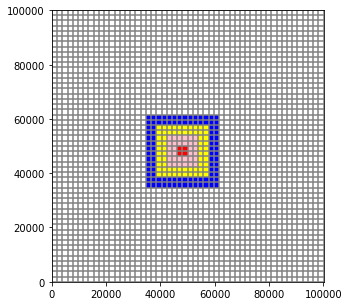

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)#, extent = (30 * delr,70 * delr,30 * delc, 70 * delc))
mm.plot_grid()
fp.plot.plot_shapefile(rf0shp, ax=ax, facecolor='blue', edgecolor='none')
fp.plot.plot_shapefile(rf1shp, ax=ax, facecolor='yellow', edgecolor='none')
fp.plot.plot_shapefile(rf2shp, ax=ax, facecolor='pink', edgecolor='none')
fp.plot.plot_shapefile(rf3shp, ax=ax, facecolor='red', edgecolor='none')

In [13]:
g.build()

(38500, 57750)

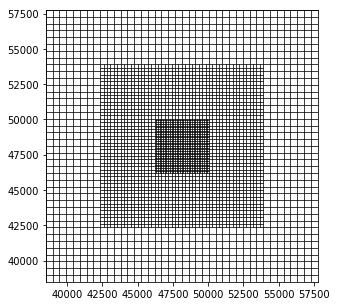

In [14]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
plt.xlim((20*delr,30*delr))
plt.ylim((20*delc,30*delc))

In [15]:
gridprops = g.get_gridprops_disv()
ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert']
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']


In [16]:
# initial conditions
ic = fp.mf6.ModflowGwfic(gwf, pname='ic', strt=0.)

In [17]:
gwf

name = theis
model_type = gwf6
version = mf6
model_relative_path = .

###################
Package ic
###################

package_name = ic
filename = theis.ic
package_type = ic
model_or_simulation_package = model
model_name = theis



In [18]:
# disv
disv = fp.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, 
                                top=0, botm=botm, 
                                nvert=nvert, vertices=vertices, 
                                cell2d=cell2d)

In [19]:
len(top)

6988

In [20]:
cell2d

[(0, 962.5, 99137.5, 5, 0, 1, 2, 3, 0, None),
 (1, 2887.5, 99137.5, 5, 1, 4, 5, 2, 1, None),
 (2, 4812.5, 99137.5, 5, 4, 6, 7, 5, 4, None),
 (3, 6737.5, 99137.5, 5, 6, 8, 9, 7, 6, None),
 (4, 8662.5, 99137.5, 5, 8, 10, 11, 9, 8, None),
 (5, 10587.5, 99137.5, 5, 10, 12, 13, 11, 10, None),
 (6, 12512.5, 99137.5, 5, 12, 14, 15, 13, 12, None),
 (7, 14437.5, 99137.5, 5, 14, 16, 17, 15, 14, None),
 (8, 16362.5, 99137.5, 5, 16, 18, 19, 17, 16, None),
 (9, 18287.5, 99137.5, 5, 18, 20, 21, 19, 18, None),
 (10, 20212.5, 99137.5, 5, 20, 22, 23, 21, 20, None),
 (11, 22137.5, 99137.5, 5, 22, 24, 25, 23, 22, None),
 (12, 24062.5, 99137.5, 5, 24, 26, 27, 25, 24, None),
 (13, 25987.5, 99137.5, 5, 26, 28, 29, 27, 26, None),
 (14, 27912.5, 99137.5, 5, 28, 30, 31, 29, 28, None),
 (15, 29837.5, 99137.5, 5, 30, 32, 33, 31, 30, None),
 (16, 31762.5, 99137.5, 5, 32, 34, 35, 33, 32, None),
 (17, 33687.5, 99137.5, 5, 34, 36, 37, 35, 34, None),
 (18, 35612.5, 99137.5, 5, 36, 38, 39, 37, 36, None),
 (19, 37537.5

In [21]:
chd_spd = [i for i in cell2d if i[1] == delr/2] + \
[i for i in cell2d if i[2] == delr/2] + \
[i for i in cell2d if i[1] == ((nrow * delr-1)+delr/2)] + \
[i for i in cell2d if i[2] == ((nrow * delr-1)+delr/2)] 


In [22]:
print(len(chd_spd))
chd_spd = list(set(chd_spd))
chd_spd = [[[0,i[0]],0] for i in chd_spd]
print(len(chd_spd))


104
103


In [23]:
chd = fp.mf6.ModflowGwfchd(gwf, save_flows=True,stress_period_data = chd_spd)

In [24]:
# npf 
hk=0.3

# node property flow
npf = fp.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                              icelltype=[0], 
                              k=[hk],
                              k33=[hk])

In [25]:
# storage
ss=0.0008
stor = fp.mf6.ModflowGwfsto(gwf, ss=ss, transient=True)

In [26]:
x = [i[1] for i in cell2d]
y = [i[2] for i in cell2d]
xc= x==np.median(x)
yc =y==np.median(y)

In [27]:
np.argmin(np.abs(np.array(x)-48500))

1907

In [28]:
np.argmin(np.abs(np.array(y)-48500))

2758

In [29]:
cell2d[1741]

(1741, 43673.4375, 53057.8125, 5, 1867, 1868, 1870, 1869, 1867, None)

In [30]:
cell2d[1716]

(1716, 42470.3125, 53539.0625, 5, 1839, 1838, 1841, 1826, 1839, None)

In [31]:
center_cell = gwf.modelgrid.intersect(np.median(x),np.median(y))

In [32]:
np.median(y)

48245.3125

In [33]:
np.where(y==np.median(y))

(array([2760, 2761, 2764, 2765, 2776, 2777, 2780, 2781, 2824, 2825, 2828,
        2829, 2840, 2841, 2844, 2845, 3400, 3401, 3404, 3405, 3416, 3417,
        3420, 3421, 3464, 3465, 3468, 3469, 3480, 3481, 3484, 3485]),)

In [34]:
np.where(xc == True)

(array([1906, 1908, 1914, 1916, 1938, 1940, 1946, 1948, 2408, 2410, 2416,
        2418, 2440, 2442, 2448, 2450, 4682, 4684, 4690, 4692, 4714, 4716,
        4722, 4724, 5184, 5186, 5192, 5194, 5216, 5218, 5224, 5226]),)

In [35]:
cell2d[1311]

(1311, 44996.875, 56546.875, 5, 1406, 1407, 1414, 1413, 1406, None)

In [36]:
np.unique(xc.astype(int) * yc.astype(int))

array([0])

In [37]:
# single well in the center
well_sp = [[(0, center_cell), -1.16]]
wel = fp.mf6.ModflowGwfwel(gwf,save_flows=True,stress_period_data=well_sp)

In [39]:
# output control
oc = fp.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [40]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model theis...
    writing model name file...
    writing package ic...
    writing package disv...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 103 based on size of stress_period_data
    writing package npf...
    writing package sto...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 


(True, [])

In [41]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_alldata()

In [42]:
head.shape

(75, 1, 1, 6988)

In [43]:
cell2d[1775]

(1775, 44154.6875, 52335.9375, 5, 1899, 1900, 1906, 1905, 1899, None)

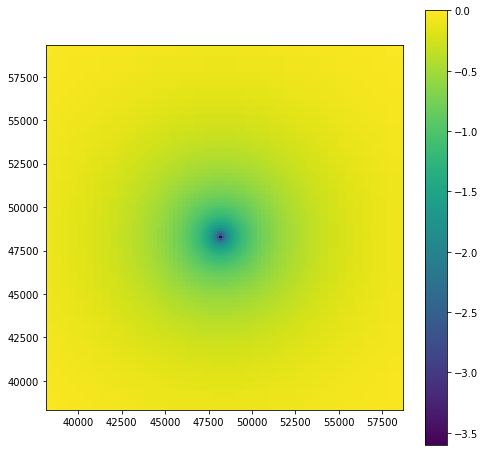

In [44]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(gwf, ax=ax)
xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
v=mm.plot_array(head[74,0,0:])
plt.xlim((xmid-10050,xmid+10500))
plt.ylim((ymid-10000,ymid+11000))
plt.colorbar(v)


In [50]:
# turn on XT3D in npf package to compare results
gwf.npf.xt3doptions=True

In [51]:
gwf.npf

package_name = npf
filename = theis.npf
package_type = npf
model_or_simulation_package = model
model_name = theis

Block options
--------------------
xt3doptions
{internal}
([True])

save_specific_discharge
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.3}

k33
{constant 0.3}



In [52]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model theis...
    writing model name file...
    writing package ic...
    writing package disv...
    writing package chd_0...
    writing package npf...
    writing package sto...
    writing package wel_0...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
imp

(True, [])

In [53]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj2 = fp.utils.HeadFile(fname)
head2 = hdobj2.get_alldata()

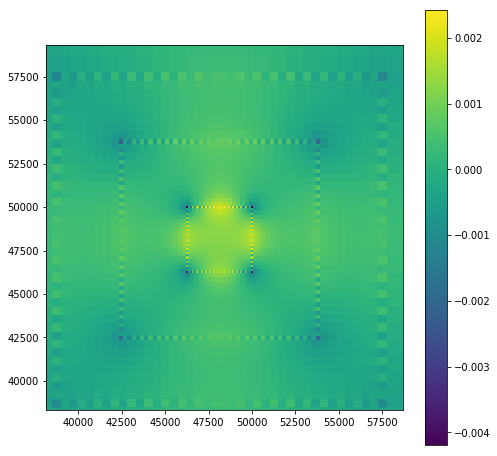

In [54]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(gwf, ax=ax)
xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
v=mm.plot_array(head[74,0,0:]-head2[74,0,0:])
plt.xlim((xmid-10050,xmid+10500))
plt.ylim((ymid-10000,ymid+11000))
plt.colorbar(v)

In [ ]:
'''
with PdfPages('theis_mf.pdf') as pdfout:
    for i, chead in enumerate(head):
        printhead = np.squeeze(chead)
        plt.figure(figsize=(8,8))
        plt.imshow(-printhead[490:510,490:510],
                  interpolation='nearest',
                  vmin=0,
                  vmax=2.7)
        plt.colorbar()
        plt.title('Theis-o-matic --> timestep{0}'.format(i))
        pdfout.savefig()
        plt.close()
'''        

In [56]:
alltimes = hdobj.get_times()

In [ ]:
import theis_script2

In [ ]:
dd_analytical = theis_script2.theis_analytical(alltimes)

In [ ]:
with PdfPages('theis_modflow_unstructured_analytical.pdf') as pdfout:
    for i in range(len(alltimes)):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(121)
        mm = fp.plot.PlotMapView(gwf, ax=ax)
        ax.set_aspect('equal')
        xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
        v=mm.plot_array(-head[i,0,:],vmin=0,vmax=1.7, cmap='magma')
        ax.set_xlim((xmid-1050,xmid+1050))
        ax.set_ylim((ymid-1050,ymid+1050))

        plt.title('MODFLOW6 Unstructured')
        fig.add_subplot(122)
        plt.imshow(dd_analytical[i], interpolation='nearest',
                  vmin=0,
                  vmax=1.7, cmap='magma')
        plt.title('Analytical')
        plt.suptitle('Theis two ways: timestep = {0}'.format(i+1))
        plt.tight_layout()
        
        pdfout.savefig()
        plt.close()

In [57]:
with PdfPages('errors_rectangular.pdf') as pdfout:
    for i in range(len(alltimes)):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1, aspect='equal')
        mm = fp.plot.PlotMapView(gwf, ax=ax)
        xmid,ymid = cell2d[center_cell][1],cell2d[center_cell][2]
        v=mm.plot_array(head[i,0,0:]-head2[i,0,0:])
        plt.xlim((xmid-10050,xmid+10500))
        plt.ylim((ymid-10000,ymid+11000))
        plt.colorbar(v, shrink=0.6)
        plt.tight_layout()
        plt.title('errors')
        pdfout.savefig()
        plt.close('all')